In [36]:
## Imports
import os
import sys
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

## Seeding 
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed

## Data Generator

In [37]:
#From RGB to GREY
import numpy as np

def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

In [38]:
class DataGen(keras.utils.Sequence):
    def __init__(self, ids, path, batch_size=8, image_size=128):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()
        
    def __load__(self, id_name):
        ## Path
        image_path = os.path.join(self.path, id_name, "images", id_name) + ".jpg"
        mask_path = os.path.join(self.path, id_name, "masks", id_name) + ".png"
        
        ## Reading Image
        image = cv2.imread(image_path, 1)
        image = cv2.resize(image, (self.image_size, self.image_size))
        mask = cv2.imread(mask_path, 1)
        mask = cv2.resize(mask, (self.image_size, self.image_size))      
        mask=rgb2gray(mask) 
        
            
        ## Normalizaing 
        image = image/255.0
        mask = mask/255.0
        
        return image, mask
    
    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
        
        image = []
        mask  = []
        
        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask)
            
        image = np.array(image)
        mask  = np.array(mask)
        
        return image, mask
    
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

## Hyperparameters

In [39]:
image_size = 128
train_path = "dataset/TEST/"
epochs = 5
batch_size = 8

## Training Ids
train_ids = next(os.walk(train_path))[1]

## Validation Data Size
val_data_size = 10

valid_ids = train_ids[:val_data_size]
train_ids = train_ids[val_data_size:]

In [40]:
gen = DataGen(train_ids, train_path, batch_size=batch_size, image_size=image_size)
x, y = gen.__getitem__(0)
print(x.shape, y.shape)

(8, 128, 128, 3) (8, 128, 128)


## Visualize The Data

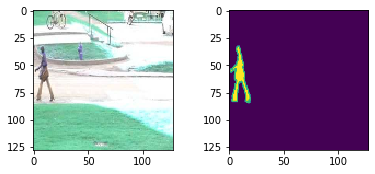

In [41]:
r = random.randint(0, len(x)-1)

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x[r])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(y[r])

## Different Convolutional Blocks

In [42]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

## UNet Model

In [43]:
def UNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16->8
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3]) #8 -> 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

In [44]:
model = UNet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_57 (Conv2D)             (None, 128, 128, 16  448         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_58 (Conv2D)             (None, 128, 128, 16  2320        ['conv2d_57[0][0]']              
                                )                                                           

## Training the model

In [45]:
train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size)
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size)

train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size

model.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, 
                    epochs=epochs)

Epoch 1/5


/tmp/ipykernel_3933/3804961854.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps,


546/546 [==============================] - 154s 278ms/step - loss: 0.0742 - acc: 0.9330 - val_loss: 0.0259 - val_acc: 0.9399
Epoch 2/5
546/546 [==============================] - 59s 107ms/step - loss: 0.0332 - acc: 0.9332 - val_loss: 0.0263 - val_acc: 0.9714
Epoch 3/5
546/546 [==============================] - 56s 103ms/step - loss: 0.0255 - acc: 0.9339 - val_loss: 0.0179 - val_acc: 0.9716
Epoch 4/5
546/546 [==============================] - 48s 88ms/step - loss: 0.0254 - acc: 0.9323 - val_loss: 0.1197 - val_acc: 0.9726
Epoch 5/5
546/546 [==============================] - 49s 90ms/step - loss: 0.0771 - acc: 0.9320 - val_loss: 0.0441 - val_acc: 0.9724


## Testing the model

In [46]:
## Save the Weights
model.save_weights("UNetW.h5")

## Dataset for prediction
x, y = valid_gen.__getitem__(1)
result = model.predict(x)

result = result > 0.5
print(x.shape,y.shape,result.shape)

1/1 [==============================] - 0s 301ms/step
(2, 128, 128, 3) (2, 128, 128) (2, 128, 128, 1)


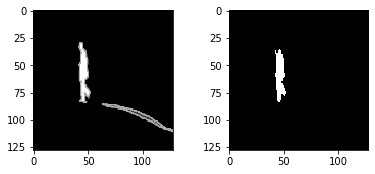

In [47]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")

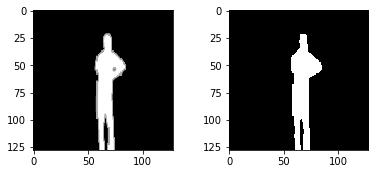

In [48]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[1]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[1]*255, (image_size, image_size)), cmap="gray")

## Testing on user provided image

(128, 128, 3)
[array([[[0.11372549, 0.11372549, 0.11372549],
        [0.11372549, 0.11372549, 0.11372549],
        [0.11372549, 0.11372549, 0.11372549],
        ...,
        [0.11372549, 0.11372549, 0.11372549],
        [0.11372549, 0.11372549, 0.11372549],
        [0.11372549, 0.11372549, 0.11372549]],

       [[0.11372549, 0.11372549, 0.11372549],
        [0.19215686, 0.12156863, 0.10980392],
        [0.25098039, 0.55686275, 0.85490196],
        ...,
        [0.11372549, 0.11372549, 0.11372549],
        [0.87843137, 0.87843137, 0.87843137],
        [0.11372549, 0.11372549, 0.11372549]],

       [[0.11372549, 0.11372549, 0.11372549],
        [0.11372549, 0.11372549, 0.11372549],
        [0.11372549, 0.11372549, 0.11372549],
        ...,
        [0.11372549, 0.11372549, 0.11372549],
        [0.11372549, 0.11372549, 0.11372549],
        [0.11372549, 0.11372549, 0.11372549]],

       ...,

       [[0.12156863, 0.08235294, 0.12941176],
        [0.9254902 , 0.93333333, 0.93333333],
       

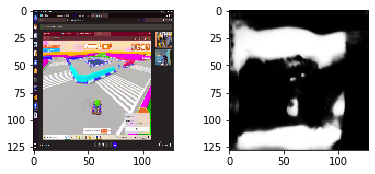

In [49]:
import cv2
import matplotlib.pyplot as plt
datapath="/home/bratin/Pictures/Screenshot from 2022-08-15 01-28-52.png"
image = cv2.imread(datapath, 1)
image = cv2.resize(image, (128,128))
image=image/255.0
imgarr=[]
imgarr.append(image)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(image)
print(image.shape)
print(imgarr)
imgarr=np.array(imgarr)
print(imgarr.shape)
res=model(imgarr)
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(res[0]*255, (image_size, image_size)), cmap="gray")
cv2.imshow('x',np.reshape(res[0]*255, (image_size, image_size)))


In [50]:
import cv2
cap = cv2.VideoCapture('/home/bratin/semseg/UNet-Segmentation-in-Keras-TensorFlow/Video/car_view.mp4')
ret, frame = cap.read()
h, w, c = frame.shape
# Check if camera opened successfully
if (cap.isOpened()== False):
  print("Error opening video stream or file")

# Read until video is completed
while (cap.isOpened()):
    # Capture frame-by-frame
    ret, frame = cap.read()
    if ret == True:
        image=frame
        image = cv2.resize(image, (128,128))
        image=image/255.0
        imgarr=[]
        imgarr.append(image)
        imgarr=np.array(imgarr)
        res=model(imgarr)
        # Display the resulting frame
        a=np.reshape(res[0]*255, (image_size, image_size))
        cv2.imshow('Result',cv2.resize(a, dsize=(w,h), interpolation=cv2.INTER_CUBIC))
        x=cv2.cvtColor(cv2.resize(a, dsize=(w,h), interpolation=cv2.INTER_CUBIC),cv2.COLOR_GRAY2RGB)
        x=np.array(x)
        #video.write(x)
        cv2.imshow('original',frame)
 
        # Press Q on keyboard to  exit
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break
 
    # Break the loop
    else:
        break
 
# When everything done, release the video capture object
cap.release()
cv2.destroyAllWindows()